###What we will cover
- data(prepare and load)
- buld model
- fitting the model to data(training)
- making predictions and evaluate a model
- saving it all together



In [80]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
torch.__version__

'1.13.1+cu116'

## 1. Data (preparing and loading)
Data can be almost anyhting 
* Excel spreadheet
* Images 
* Vids etc
* text

Machine learning is a game of two parts:
1. Get data into a numerical representation
2. build a model to learn pattenrns in that numerical representation
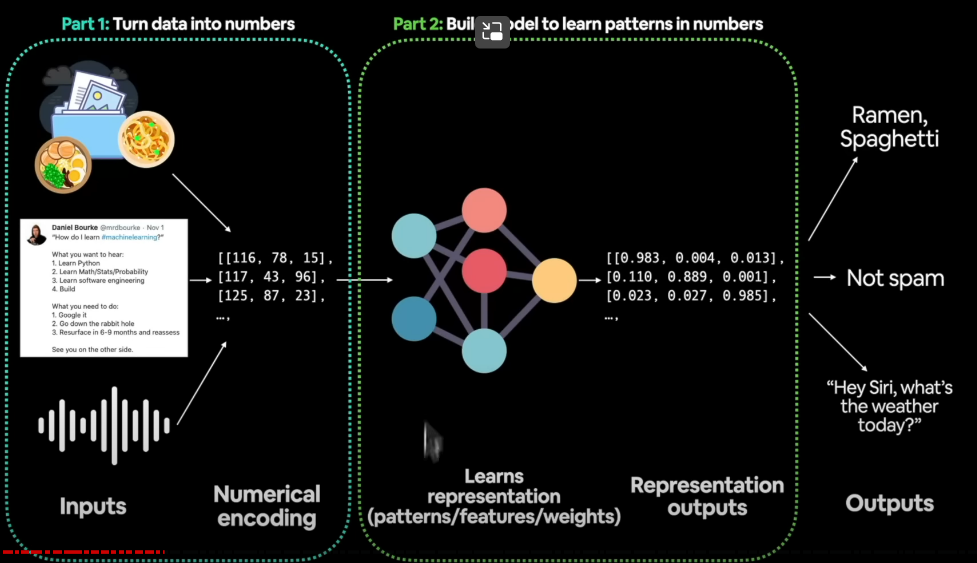

###Lets create the new data using lr
Use linear reg. formula to make a straight line with known parameters

In [3]:
#Create *known* parameters
w=0.7
b=0.3

#Create
start=0
end=1
step=0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
#X = torch.arange(start,end,step).reshape(-1,1) another way
y=w*X + b

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X),len(y)

(50, 50)

### Split the data into training and test set (very imp)
- Lets Create training and test data

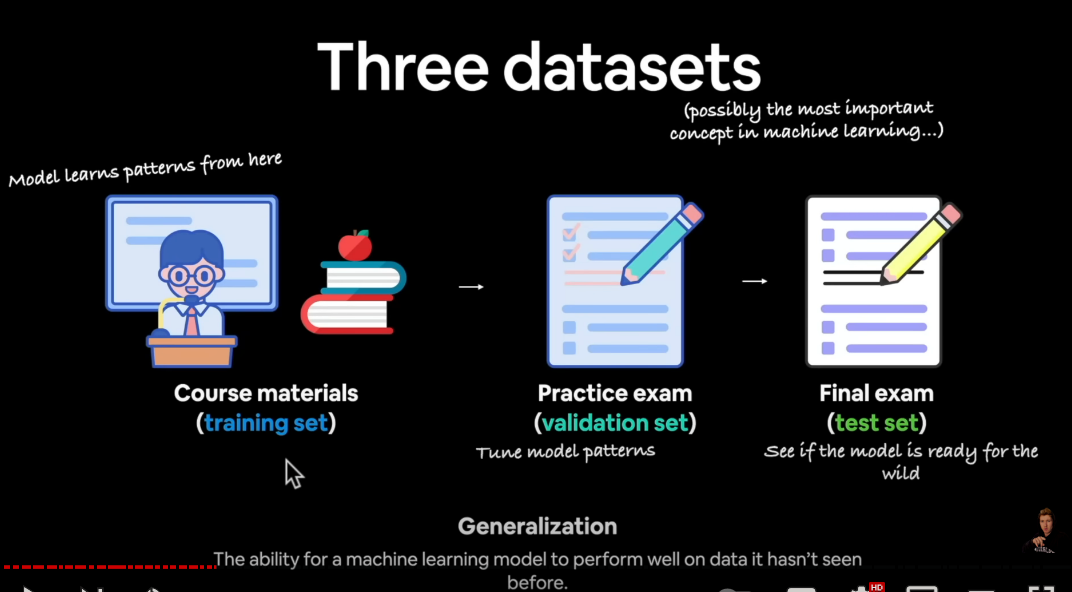

In [5]:
train_split=int(0.8*len(X))
train_split

40

In [6]:
X_train,y_train=X[:train_split],y[:train_split]
X_test,y_test=X[train_split:],y[train_split:]

len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

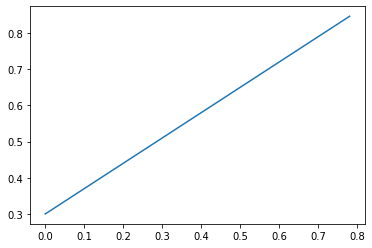

In [7]:
plt.plot(X_train,y_train);

In [8]:
def plot_predictions(train_data=X_train,
                      train_labels=y_train,
                      test_data=X_test,
                      test_labels=y_test,
                      p=None):
  """
  Plots training data,test data and compare pred.
  """
  plt.figure(figsize=(10,7))
  #plot training data
  plt.scatter(train_data,train_labels,c="b",s=4,label="Training data")
  
  #plot test data
  plt.scatter(test_data,test_labels,c="g",s=4,label="Test data")

  #Are there preds?
  if p is not None:
    plt.scatter(test_data,p,c="r",s=4,label="Predictions")

  #Show the legend
  plt.legend(prop={"size":14})   


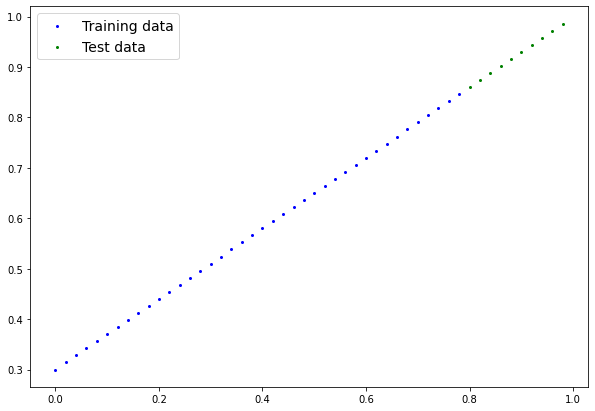

In [9]:
plot_predictions() 

In [10]:
## 2. Build model
from torch import nn
class LinearRegression(nn.Module):
  def __init__(self):
    super().__init__()
    # torch.manual_seed(42)
    self.weights=nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
    # torch.manual_seed(42)
    self.bias=nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))

  def forward(self,x:torch.Tensor)->torch.Tensor:
    return self.weights*x +self.bias





In [11]:
torch.manual_seed(42)
lr=LinearRegression()
list(lr.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [12]:
# train=lr.forward(X_train)
pred=lr(X_test)
pred

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

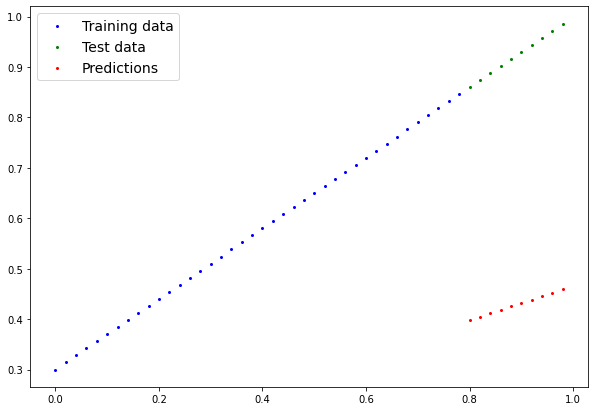

In [13]:
plot_predictions(p=pred.detach().numpy())

In [14]:
(pred-y_test).mean()

tensor(-0.4945, grad_fn=<MeanBackward0>)

In [15]:
with torch.inference_mode():
  x=lr(X_test)
x

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

### a loss funcn is used to test the accuracy of the model
- A loss function is used to measure the distance of pred and actual val
- A optimizer takes into account the loss of a MODEL and adjust the parameters w and b to improve the loss funcn
- In ml loss func and cost func are samem

In [16]:
  #loss funcn
loss_fn=nn.L1Loss()
#optimizers(stochastic gradient descent)
optimizer=torch.optim.SGD(params=lr.parameters(),lr=0.01)

###**Q:**Which loss function to use??
**A:**This will be problem specific and well get better at it with experience
For ex:For a regression problem the loss funcn like mae or l1loss in pytorch is 
sufficient.

 But for the classification data we use categorical loss funcn,


###Building a training and testing loop in pytorch
A couple of things things we need in training loop
0. look through data
1. FOrward pass(this involves the data moving forward through funcn `forward()`
2. Calculate the loss (compare forward pass pred to ground truth labels
3. Optimizers zero grad
4. **backpropogation**Loss backward or backward pass go from op to inp layer or move backward in n/w to calculate the gradients of each of params of our model wrt to loss
5. Use the optimizer obj to adjust our w and b params to try and improve the loss  

In [77]:
loss_list=[]
#an epoch is one loop
epochs=200

# 0. loop through data
for epoch in range(epochs):
  #set he model to training mode
  lr.train() #train mode sets all the params that require grad to require grad
  lr.eval() #turns off the grad tracking
  y_pred=lr(X_train)

  #2. calc the loss
  loss=loss_fn(y_pred,y_train)
  loss_list.append(loss.detach().numpy())
#optimizer zero grad
  optimizer.zero_grad()

#back prop on loss wrt to parameters of model
  loss.backward()

  #step the optimizers(perform gd)
  optimizer.step()


In [68]:
list(lr.parameters())

[Parameter containing:
 tensor([0.6951], requires_grad=True), Parameter containing:
 tensor([0.2993], requires_grad=True)]

In [69]:
pred=lr(X_test)
(pred-y_test).detach().numpy()


array([[-0.00458491],
       [-0.00468224],
       [-0.00477958],
       [-0.00487703],
       [-0.00497437],
       [-0.00507182],
       [-0.00516915],
       [-0.00526661],
       [-0.00536394],
       [-0.00546128]], dtype=float32)

In [70]:
loss=loss_fn(pred,y_test)
loss

tensor(0.0050, grad_fn=<MeanBackward0>)

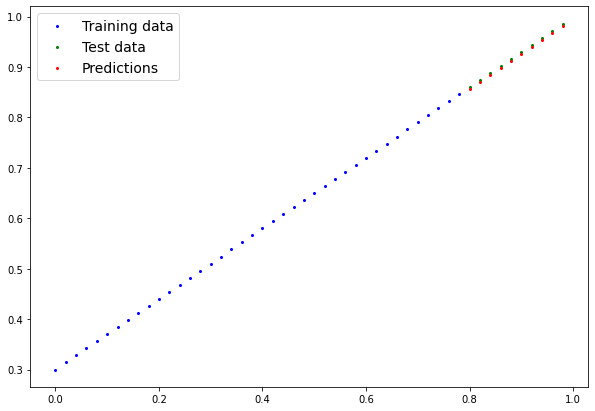

In [71]:
plot_predictions(p=pred.detach().numpy())

In [87]:
def lossfn_curve(loss,preds):
  plt.scatter(preds,loss)
  plt.xlabel("Pred")
  plt.ylabel("Loss")


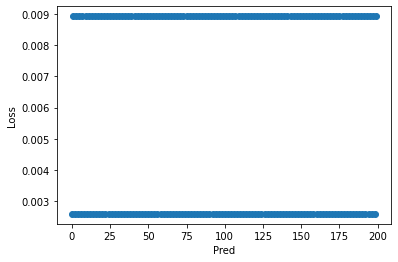

In [88]:
lossfn_curve(loss_list,range(epochs))

In [89]:
loss_list=np.array(loss_list)
loss_list.shape
epochs

200